In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import wave,os,librosa,tqdm,time,shutil
import pandas as pd
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import librosa, os, cv2, pickle, tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization,Input
from tensorflow.keras.optimizers import Adam,SGD,RMSprop,Adadelta,Adagrad,Adamax,Nadam
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from imblearn.over_sampling import SMOTE

In [6]:
feats = pd.read_csv('/kaggle/input/crema-d-opensmile-all-emo-16khz-20db-trim-then-nr/CREMA_D_OpenSMILE_Features_16khz_trim_then_NR.csv')
feats

,audspec_lengthL1norm_sma_range,audspec_lengthL1norm_sma_maxPos,audspec_lengthL1norm_sma_minPos,audspec_lengthL1norm_sma_quartile1,audspec_lengthL1norm_sma_quartile2,audspec_lengthL1norm_sma_quartile3,audspec_lengthL1norm_sma_iqr1-2,audspec_lengthL1norm_sma_iqr2-3,audspec_lengthL1norm_sma_iqr1-3,audspec_lengthL1norm_sma_percentile1.0,...,mfcc_sma_de[14]_peakRangeRel,mfcc_sma_de[14]_peakMeanAbs,mfcc_sma_de[14]_peakMeanMeanDist,mfcc_sma_de[14]_peakMeanRel,mfcc_sma_de[14]_minRangeRel,mfcc_sma_de[14]_meanRisingSlope,mfcc_sma_de[14]_stddevRisingSlope,mfcc_sma_de[14]_meanFallingSlope,mfcc_sma_de[14]_stddevFallingSlope,label
0,0.283087,0.351695,0.114407,0.019516,0.086236,0.133450,0.066720,0.047213,0.113933,0.010054,...,0.626081,2.252254,2.276943,-19.236828,0.438872,92.671160,43.824640,91.460365,57.257088,disgust
1,0.450796,0.339744,0.666667,0.023399,0.030485,0.190735,0.007086,0.160250,0.167335,0.016857,...,0.578092,1.746136,1.748039,-19.999828,0.462072,85.607530,38.963768,74.271410,41.101090,happy
2,0.582389,0.271605,0.000000,0.108567,0.189416,0.266452,0.080849,0.077037,0.157886,0.022642,...,0.616435,3.013976,2.976359,19.027126,0.601453,105.442880,41.915794,116.730110,62.343582,happy
3,0.938659,0.348315,0.842697,0.195384,0.261150,0.392237,0.065766,0.131087,0.196853,0.076487,...,0.543531,2.502343,2.541978,-18.542135,0.677923,109.665680,53.580017,78.247660,37.373333,disgust
4,0.958477,0.364780,0.000000,0.086069,0.137500,0.252903,0.051431,0.115403,0.166835,0.037426,...,0.351511,2.328939,2.472584,-13.249281,0.737216,127.037125,41.492443,110.201290,50.369890,disgust
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7437,0.986579,0.256198,0.000000,0.187007,0.303785,0.387124,0.116778,0.083339,0.200117,0.033847,...,0.636325,3.099806,3.043244,18.189360,0.565104,137.267580,67.798990,144.334520,60.653490,angry
7438,2.301252,0.051282,0.863248,0.247922,0.476041,0.770648,0.228119,0.294607,0.522726,0.016104,...,0.766714,1.862289,2.148709,-6.501959,0.519850,116.101166,59.045696,110.876350,58.675920,angry
7439,1.518607,0.365979,0.134021,0.120969,0.235736,0.600588,0.114767,0.364852,0.479620,0.011524,...,0.497689,2.436864,2.588179,-13.212930,0.694735,117.924760,45.889970,127.106730,57.104458,angry
7440,0.331285,0.243243,0.822394,0.015225,0.051348,0.135942,0.036122,0.084595,0.120717,0.010996,...,0.526080,2.200988,2.183082,19.591042,0.598791,83.836845,35.650146,96.719200,48.398067,sad


In [7]:
feats.label.value_counts()

label
disgust    1271
happy      1271
sad        1271
fear       1271
angry      1271
neutral    1087
Name: count, dtype: int64

In [8]:
feats = feats[feats['label'].isin(['angry','happy','sad','neutral'])]
feats.label.value_counts()

label
happy      1271
sad        1271
angry      1271
neutral    1087
Name: count, dtype: int64

In [9]:
def split_preprocess(df,apply_smote=False,rs=536,returnscalerle=False):
  x = df.drop(['label'], axis=1)
  y = df['label']
  trainX, testX, trainY, testY = train_test_split(x, y, test_size=0.2, random_state=rs,stratify=y)
  scaler = StandardScaler()
  trainX = scaler.fit_transform(trainX)
  testX = scaler.transform(testX)
  if apply_smote:
    smote = SMOTE(random_state=42)
    trainX, trainY = smote.fit_resample(trainX, trainY)
  le = LabelEncoder()
  trainY_enc = to_categorical(le.fit_transform(trainY))
  testY_enc = to_categorical(le.transform(testY))
  if returnscalerle:
    return trainX, testX, trainY, testY, trainY_enc,testY_enc, scaler,le
  return trainX, testX, trainY, testY,trainY_enc,testY_enc

In [10]:
trainX, testX, trainY, testY, trainY_enc, testY_enc,scaler,le = split_preprocess(feats,rs=6,returnscalerle=True)
model = Sequential()
model.add(Input((trainX.shape[1],)))
model.add(Dense(20, activation='relu',kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(40, activation='relu',kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(80, activation='relu',kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(len(np.unique(trainY)), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 20)             │       127,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 20)             │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 40)             │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 40)             │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 80)             │         3,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 80)             │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           324 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,484 (517.52 KB)

 Trainable params: 132,204 (516.42 KB)

 Non-trainable params: 280 (1.09 KB)

In [11]:
mpath = '/kaggle/working/ann_model_cremad_opensmile.keras'
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True),
             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=15, min_lr=0.00001),
             tf.keras.callbacks.ModelCheckpoint(filepath=mpath, monitor='val_accuracy', save_best_only=True,verbose=1)]
history = model.fit(trainX, trainY_enc, epochs=500, batch_size=32, validation_data=(testX, testY_enc),callbacks=callbacks)
_, accuracy = model.evaluate(testX, testY_enc)
print('\nAccuracy: %.2f' % (accuracy*100))
predictions = model.predict(testX)
predicted_labels = le.inverse_transform(np.argmax(predictions, axis=1))
print(classification_report(testY, predicted_labels))
new_mpath = f"/kaggle/working/ann_model_cremad_4emo_opensmile_val_acc_{accuracy*100:.2f}.keras"
shutil.move(mpath, new_mpath)

Epoch 1/500


I0000 00:00:1732201495.730172     105 service.cc:145] XLA service 0x7f96e80034c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732201495.730223     105 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732201495.730227     105 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 74/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4071 - loss: 2.6840

I0000 00:00:1732201501.136233     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4469 - loss: 2.5636
Epoch 1: val_accuracy improved from -inf to 0.66939, saving model to /kaggle/working/ann_model_cremad_opensmile.keras
123/123 ━━━━━━━━━━━━━━━━━━━━ 14s 50ms/step - accuracy: 0.4475 - loss: 2.5616 - val_accuracy: 0.6694 - val_loss: 1.8860 - learning_rate: 0.0010
Epoch 2/500
116/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6386 - loss: 1.9145
Epoch 2: val_accuracy improved from 0.66939 to 0.70408, saving model to /kaggle/working/ann_model_cremad_opensmile.keras
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6388 - loss: 1.9117 - val_accuracy: 0.7041 - val_loss: 1.6121 - learning_rate: 0.0010
Epoch 3/500
116/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6968 - loss: 1.6079
Epoch 3: val_accuracy did not improve from 0.70408
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6968 - loss: 1.6061 - val_accuracy: 0.6959 - val_loss: 1.4900 - learning_rate: 0.0010
Epoch 4/500
114/123 ━━━━━━━━━━━━━━━

'/kaggle/working/ann_model_cremad_4emo_opensmile_val_acc_74.59.keras'

In [12]:
from tensorflow.keras.regularizers import l1,l2,l1_l2
    
def getRandomHPPMS():
    params = {}
    params['rs_split'] = np.random.randint(0,1000)
    #params['rs_split'] = 6
    params['num_HL'] = np.random.randint(2,4+1)
    for i in range(1,params['num_HL']+1):
        params[f'units_{i}'] = np.random.choice(range(64,512+2,2))
        params[f'KR_{i}'] = np.random.choice(['l1','l2','l1l2','none'])
        params[f'BN_{i}'] = np.random.choice([True,False])
        #params[f'dropout_rate_{i}'] = np.random.choice(np.round(np.arange(0,0.5+0.1,0.1),1))
        params[f'dropout_rate_{i}'] = np.round(np.random.uniform(0,0.5),4)
    params['learning_rate'] = np.random.uniform(0.0001,0.005)
    optims = ['Adam','SGD','RMSprop','Adadelta','Adagrad','Adamax','Nadam']
    params['optimizer'] = np.random.choice(optims)
    params['batch_size'] = np.random.choice(range(32,132,4))
    params['adpLR'] = np.random.choice([True,False])
    params['apply_smote'] = np.random.choice([True,False])
    return params

def buildntrainmodel(params,feats,max_epochs=500):
    trainX, testX, trainY, testY, trainY_enc, testY_enc,scaler,le = split_preprocess(feats,rs=params['rs_split'],apply_smote=params['apply_smote'],returnscalerle=True)
    model = Sequential()
    model.add(Input((trainX.shape[1],)))
    for i in range(1,params['num_HL']+1):
        kern = {'l1':l1(),'l2':l2(),'l1l2':l1_l2(),'none':None}
        model.add(Dense(units=params[f'units_{i}'],activation='relu',kernel_regularizer=kern[params[f'KR_{i}']]))
        if params[f'BN_{i}']:
            model.add(BatchNormalization())
        if params[f'dropout_rate_{i}']>0:
            model.add(Dropout(params[f'dropout_rate_{i}']))
    model.add(Dense(len(np.unique(trainY)), activation='softmax'))
    optimizer_dict = {'Adam': Adam(learning_rate=params['learning_rate']),
                      'SGD': SGD(learning_rate=params['learning_rate']),
                      'RMSprop': RMSprop(learning_rate=params['learning_rate']),
                      'Adadelta': Adadelta(learning_rate=params['learning_rate']),
                      'Adagrad': Adagrad(learning_rate=params['learning_rate']),
                      'Adamax': Adamax(learning_rate=params['learning_rate']),
                      'Nadam': Nadam(learning_rate=params['learning_rate'])}
    
    model.compile(optimizer=optimizer_dict[params['optimizer']], loss='categorical_crossentropy', metrics=['accuracy'])
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True)]
    if params['adpLR']:
        callbacks.append(tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=15, min_lr=0.00001))
    histann = model.fit(trainX, trainY_enc, epochs=max_epochs, batch_size=params['batch_size'],validation_data=(testX, testY_enc),callbacks=callbacks)
    _, accuracy = model.evaluate(testX, testY_enc)
    splits = (trainX, testX, trainY, testY, trainY_enc, testY_enc,scaler,le)
    return accuracy,params,model,splits,histann

In [22]:
import IPython.display as ipd
def plot_history(hist,acc,id):
  plt.figure(figsize=(12, 6))
  plt.suptitle(f'Training & Validation Curves for Best ANN Model - Val_Acc={acc*100:.2f}% at Trial #{id}', fontsize=16)
  plt.subplot(1, 2, 1)
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper right')

  plt.subplot(1, 2, 2)
  plt.plot(hist.history['accuracy'])
  plt.plot(hist.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='lower right')
  plt.tight_layout()
  plt.show()
    
def tune_hyperparams(ntrials,feats,max_epochs=500):
    max_acc = 0
    totm = 0
    phist = dict()
    histories = dict()
    for i in range(1,ntrials+1):
        st = time.time()
        print(f"\nRunning Trial #{i}\n")
        params = getRandomHPPMS()
        if i==1:
            best_params = params
        print(f"{'Current Value':<15}{'|Best Value So Far':<21}{'|Hyperparameter'}")
        print(f"{'-' * 15}|{'-' * 20}|{'-' * 15}")
        for param, value in params.items():
            best_value = best_params.get(param, 'N/A')
            if param=='learning_rate':
                best_value,value = round(best_value,3),round(value,3)
            print(f"{str(value):<15}|{str(best_value):<20}|{param}")
        print()
        acc,params,model,splits,histann = buildntrainmodel(params,feats,max_epochs=max_epochs)
        trainX, testX, trainY, testY, trainY_enc, testY_enc,scaler,le = splits
        fparams = frozenset(params.items())
        phist[fparams] = acc
        histories[i] = histann
        if acc>max_acc:
            max_acc = acc
            best_params = params
            best_trial = i
            best_model = model
        ipd.clear_output(wait=True)
        en = time.time()
        tm = en-st
        totm+=tm
        ep = len(histann.history['accuracy'])
        tracc = max(histann.history['accuracy'])
        print(f"Trial {i} Complete [{int(tm/3600)}h {int(tm/60)}m {int(tm%60)}s] - Trained for {ep} epochs")
        print(f"train_accuracy = {tracc*100:.3f}%")
        print(f"val_accuracy = {acc*100:.3f}%")
        print(f"Overfitting Difference = {(tracc-acc)*100:.3f}%\n")
        print(f"Best val_accuracy So Far: {max_acc*100:.3f}% at Trial #{best_trial}")
        print(f"Total time elapsed: [{int(totm/3600)}h {int(totm/60)}m {int(totm%60)}s]")
    print(f"Best Hyperparameters: {best_params}")
    print("Best Model Summary:")
    print(best_model.summary())
    best_hist = histories[best_trial]
    plot_history(best_hist,max_acc,best_trial)
    trainX, testX, trainY, testY, trainY_enc, testY_enc,scaler,le = split_preprocess(feats,rs=best_params['rs_split'],apply_smote=best_params['apply_smote'],returnscalerle=True)
    predictions = best_model.predict(testX)
    predicted_labels = le.inverse_transform(np.argmax(predictions, axis=1))
    cm = confusion_matrix(testY, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=le.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix for Best ANN Model")
    plt.show()
    print(f"\nAccuracy = {accuracy_score(testY,predicted_labels)*100:.3f}%\n")
    print(classification_report(testY, predicted_labels))
    best_model.save(f'/kaggle/working/ann_model_cremad_4emo_opensmile_val_acc_{max_acc*100:.3f}.keras')
    return max_acc, best_params, best_trial, best_model, phist,histories

Trial 20 Complete [0h 0m 25s] - Trained for 55 epochs
train_accuracy = 63.913%
val_accuracy = 68.673%
Overfitting Difference = -4.760%

Best val_accuracy So Far: 77.347% at Trial #14
Total time elapsed: [0h 12m 9s]
Best Hyperparameters: {'rs_split': 628, 'num_HL': 3, 'units_1': 374, 'KR_1': 'none', 'BN_1': False, 'dropout_rate_1': 0.3323, 'units_2': 470, 'KR_2': 'none', 'BN_2': False, 'dropout_rate_2': 0.2641, 'units_3': 118, 'KR_3': 'l1', 'BN_3': True, 'dropout_rate_3': 0.3216, 'learning_rate': 0.0020677482354334842, 'optimizer': 'Adagrad', 'batch_size': 80, 'adpLR': False, 'apply_smote': True}
Best Model Summary:


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_57 (Dense)                │ (None, 374)            │     2,383,876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 374)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 470)            │       176,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 470)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 118)            │        55,578 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 118)            │           472 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 118)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 4)              │           476 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,233,070 (19.96 MB)

 Trainable params: 2,616,416 (9.98 MB)

 Non-trainable params: 236 (944.00 B)

 Optimizer params: 2,616,418 (9.98 MB)

None


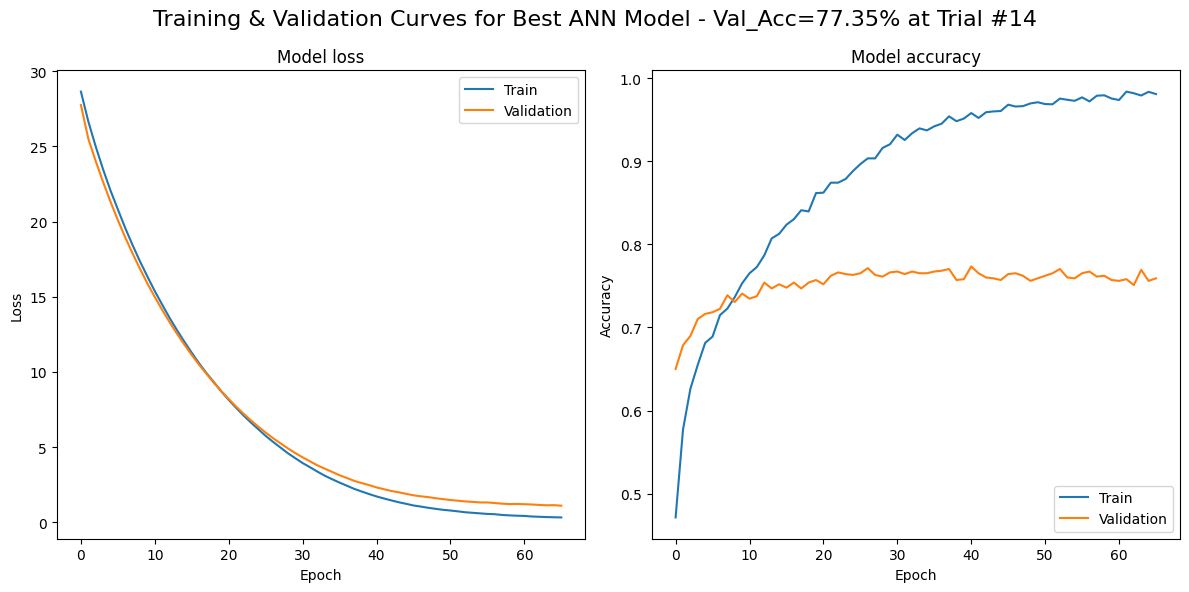

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


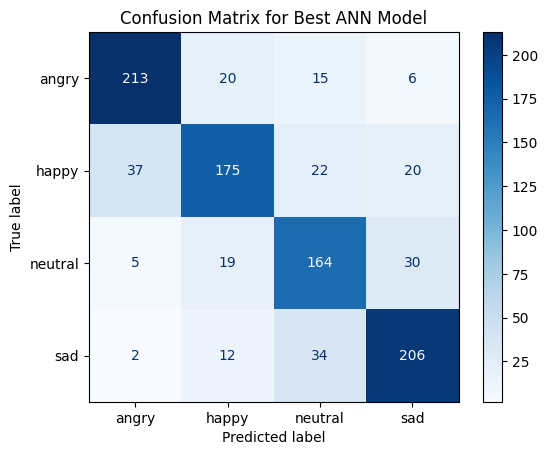


Accuracy = 77.347%

              precision    recall  f1-score   support

       angry       0.83      0.84      0.83       254
       happy       0.77      0.69      0.73       254
     neutral       0.70      0.75      0.72       218
         sad       0.79      0.81      0.80       254

    accuracy                           0.77       980
   macro avg       0.77      0.77      0.77       980
weighted avg       0.77      0.77      0.77       980



In [14]:
max_acc, best_params, best_trial, best_model, phist, histories = tune_hyperparams(ntrials=20,feats=feats,max_epochs=500)

In [15]:
data = []
for params, acc in phist.items():
    hppms = dict(params)
    hppms['accuracy'] = acc
    data.append(hppms)
df = pd.DataFrame(data)
df = df.reindex(sorted(df.columns), axis=1)
df = df[[col for col in sorted(df.columns) if col != 'accuracy'] + ['accuracy']]
df.sort_values('accuracy',ascending=False,inplace=True,ignore_index=True)
df

,BN_1,BN_2,BN_3,BN_4,KR_1,KR_2,KR_3,KR_4,adpLR,apply_smote,...,dropout_rate_4,learning_rate,num_HL,optimizer,rs_split,units_1,units_2,units_3,units_4,accuracy
0,False,False,True,NaN,none,none,l1,NaN,False,True,...,NaN,0.002068,3,Adagrad,628,374,470,118.0,NaN,0.773469
1,False,False,False,NaN,l1l2,none,l1,NaN,True,False,...,NaN,0.001428,3,Nadam,689,282,64,434.0,NaN,0.772449
2,False,True,NaN,NaN,none,l2,NaN,NaN,True,True,...,NaN,0.004212,2,Adagrad,751,440,274,NaN,NaN,0.772449
3,False,False,False,NaN,l1l2,l2,none,NaN,True,True,...,NaN,0.000512,3,Adagrad,151,338,146,334.0,NaN,0.763265
4,False,False,True,NaN,l1,l2,none,NaN,True,True,...,NaN,0.002500,3,Adadelta,201,340,490,254.0,NaN,0.762245
5,True,True,False,True,none,l1l2,l2,l1,False,True,...,0.1144,0.004450,4,Adam,248,122,210,448.0,240.0,0.758163
6,False,False,True,NaN,l2,l1,l1,NaN,True,False,...,NaN,0.002526,3,Adamax,65,202,196,460.0,NaN,0.757143
7,True,False,False,NaN,l1,none,l1,NaN,True,False,...,NaN,0.001233,3,Adagrad,18,510,484,434.0,NaN,0.756122
8,True,True,False,NaN,l1l2,l1l2,l1,NaN,False,False,...,NaN,0.000984,3,Adagrad,60,186,168,126.0,NaN,0.755102
9,False,False,False,False,l2,none,none,l2,False,False,...,0.1619,0.004464,4,Nadam,921,302,454,68.0,376.0,0.745918


In [16]:
numerical_features = df.iloc[:,:-1].select_dtypes(include=['int64', 'float64'])
categorical_features = df.select_dtypes(include=['object', 'category','bool'])
correlation_matrix = numerical_features.corrwith(df['accuracy'], method='pearson')
print(correlation_matrix.sort_values(ascending=False))

learning_rate     0.245930
units_1           0.215058
rs_split          0.135710
num_HL            0.111625
units_3           0.094325
units_2           0.068177
dropout_rate_2   -0.101842
dropout_rate_3   -0.144873
batch_size       -0.304262
dropout_rate_1   -0.345963
units_4          -0.547731
dropout_rate_4   -0.889875
dtype: float64


In [17]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
for col in categorical_features:
    model = ols(f'accuracy ~ C({col})', data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(f"ANOVA result for {col}:\n", anova_table)

ANOVA result for BN_1:
             sum_sq    df         F    PR(>F)
C(BN_1)   0.001741   1.0  0.964911  0.338973
Residual  0.032487  18.0       NaN       NaN
ANOVA result for BN_2:
             sum_sq    df         F    PR(>F)
C(BN_2)   0.001910   1.0  1.063583  0.316058
Residual  0.032319  18.0       NaN       NaN
ANOVA result for BN_3:
             sum_sq    df         F    PR(>F)
C(BN_3)   0.000718   1.0  0.676815  0.425519
Residual  0.013788  13.0       NaN       NaN
ANOVA result for BN_4:
             sum_sq   df         F    PR(>F)
C(BN_4)   0.001214  1.0  0.552505  0.511214
Residual  0.006590  3.0       NaN       NaN
ANOVA result for KR_1:
             sum_sq    df         F    PR(>F)
C(KR_1)   0.009090   3.0  1.928599  0.165664
Residual  0.025138  16.0       NaN       NaN
ANOVA result for KR_2:
             sum_sq    df         F    PR(>F)
C(KR_2)   0.000926   3.0  0.148316  0.929258
Residual  0.033302  16.0       NaN       NaN
ANOVA result for KR_3:
             sum_sq    df 

In [18]:
for col in categorical_features:
    print(df.groupby(col)['accuracy'].mean().sort_values(ascending=False))

BN_1
False    0.740221
True     0.721173
Name: accuracy, dtype: float64
BN_2
True     0.745918
False    0.725432
Name: accuracy, dtype: float64
BN_3
False    0.749708
True     0.735842
Name: accuracy, dtype: float64
BN_4
True     0.729252
False    0.697449
Name: accuracy, dtype: float64
KR_1
l1l2    0.756633
none    0.754490
l2      0.723214
l1      0.708601
Name: accuracy, dtype: float64
KR_2
l1      0.741837
l1l2    0.739116
l2      0.727806
none    0.725802
Name: accuracy, dtype: float64
KR_3
none    0.748980
l1      0.743878
l2      0.743197
l1l2    0.696939
Name: accuracy, dtype: float64
KR_4
l1      0.758163
l2      0.709184
l1l2    0.696939
Name: accuracy, dtype: float64
adpLR
True     0.735250
False    0.729365
Name: accuracy, dtype: float64
apply_smote
False    0.744388
True     0.724745
Name: accuracy, dtype: float64
optimizer
Nadam       0.759184
Adamax      0.757143
Adagrad     0.747230
SGD         0.738265
RMSprop     0.732653
Adam        0.728061
Adadelta    0.674830
Name

Trial 30 Complete [0h 0m 34s] - Trained for 66 epochs
train_accuracy = 55.969%
val_accuracy = 60.102%
Overfitting Difference = -4.133%

Best val_accuracy So Far: 78.367% at Trial #18
Total time elapsed: [0h 18m 18s]
Best Hyperparameters: {'rs_split': 751, 'num_HL': 4, 'units_1': 362, 'KR_1': 'none', 'BN_1': False, 'dropout_rate_1': 0.2676, 'units_2': 396, 'KR_2': 'none', 'BN_2': False, 'dropout_rate_2': 0.4965, 'units_3': 320, 'KR_3': 'l2', 'BN_3': True, 'dropout_rate_3': 0.1802, 'units_4': 332, 'KR_4': 'none', 'BN_4': False, 'dropout_rate_4': 0.3311, 'learning_rate': 0.004869714838766496, 'optimizer': 'Adamax', 'batch_size': 76, 'adpLR': False, 'apply_smote': False}
Best Model Summary:


Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_151 (Dense)               │ (None, 362)            │     2,307,388 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_113 (Dropout)           │ (None, 362)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_152 (Dense)               │ (None, 396)            │       143,748 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_114 (Dropout)           │ (None, 396)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_153 (Dense)               │ (None, 320)            │       127,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_60          │ (None, 320)            │         1,280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_115 (Dropout)           │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_154 (Dense)               │ (None, 332)            │       106,572 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_116 (Dropout)           │ (None, 332)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_155 (Dense)               │ (None, 4)              │         1,332 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,060,802 (30.75 MB)

 Trainable params: 2,686,720 (10.25 MB)

 Non-trainable params: 640 (2.50 KB)

 Optimizer params: 5,373,442 (20.50 MB)

None


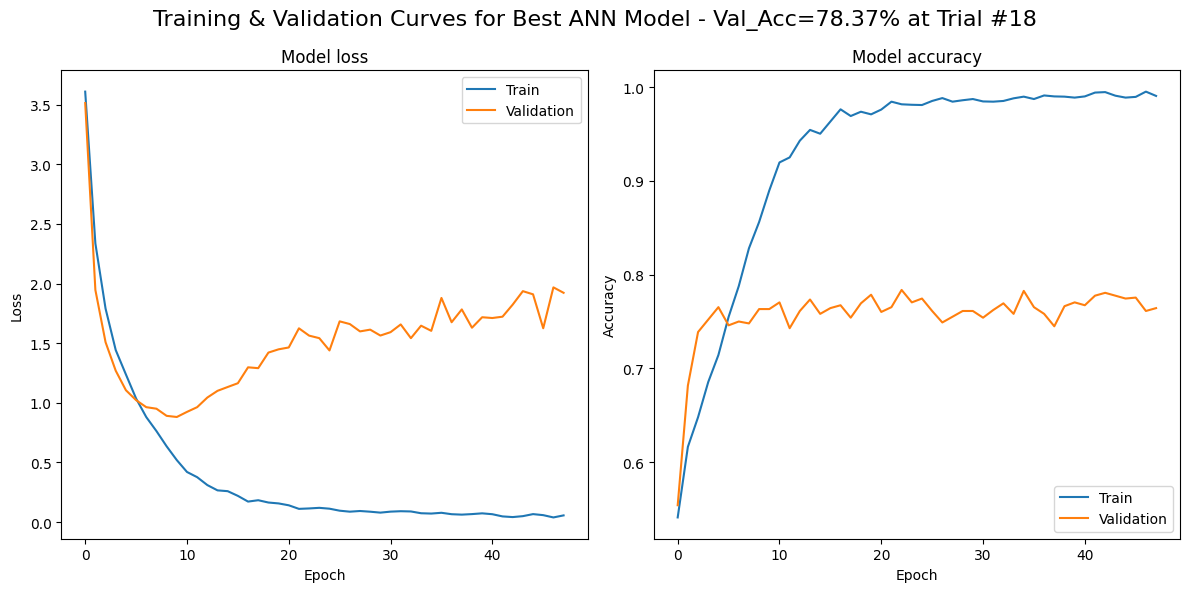

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


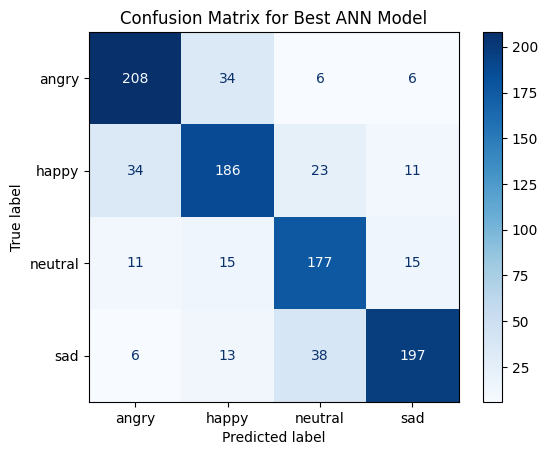


Accuracy = 78.367%

              precision    recall  f1-score   support

       angry       0.80      0.82      0.81       254
       happy       0.75      0.73      0.74       254
     neutral       0.73      0.81      0.77       218
         sad       0.86      0.78      0.82       254

    accuracy                           0.78       980
   macro avg       0.78      0.78      0.78       980
weighted avg       0.79      0.78      0.78       980



In [19]:
max_acc, best_params, best_trial, best_model, phist, histories = tune_hyperparams(ntrials=30,feats=feats,max_epochs=500)

In [24]:
def getRandomHPPMS():
    params = {}
    #params['rs_split'] = np.random.randint(0,1000)
    params['rs_split'] = 205
    params['num_HL'] = np.random.randint(2,4+1)
    for i in range(1,params['num_HL']+1):
        params[f'units_{i}'] = np.random.choice(range(64,512+2,2))
        params[f'KR_{i}'] = np.random.choice(['l1','l2','l1l2','none'])
        params[f'BN_{i}'] = np.random.choice([True,False])
        #params[f'dropout_rate_{i}'] = np.random.choice(np.round(np.arange(0,0.5+0.1,0.1),1))
        params[f'dropout_rate_{i}'] = np.round(np.random.uniform(0,0.5),4)
    params['learning_rate'] = np.random.uniform(0.0001,0.005)
    optims = ['Adam','SGD','RMSprop','Adadelta','Adagrad','Adamax','Nadam']
    params['optimizer'] = np.random.choice(optims)
    params['batch_size'] = np.random.choice(range(32,132,4))
    params['adpLR'] = np.random.choice([True,False])
    params['apply_smote'] = np.random.choice([True,False])
    return params

Trial 20 Complete [0h 0m 35s] - Trained for 73 epochs
train_accuracy = 97.500%
val_accuracy = 75.306%
Overfitting Difference = 22.194%

Best val_accuracy So Far: 78.469% at Trial #13
Total time elapsed: [0h 9m 54s]
Best Hyperparameters: {'rs_split': 205, 'num_HL': 3, 'units_1': 398, 'KR_1': 'l1l2', 'BN_1': False, 'dropout_rate_1': 0.4716, 'units_2': 96, 'KR_2': 'none', 'BN_2': True, 'dropout_rate_2': 0.1288, 'units_3': 80, 'KR_3': 'l1l2', 'BN_3': True, 'dropout_rate_3': 0.1508, 'learning_rate': 0.00225168875005398, 'optimizer': 'Adagrad', 'batch_size': 84, 'adpLR': True, 'apply_smote': True}
Best Model Summary:


Model: "sequential_113"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_457 (Dense)               │ (None, 398)            │     2,536,852 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_344 (Dropout)           │ (None, 398)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_458 (Dense)               │ (None, 96)             │        38,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_164         │ (None, 96)             │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_345 (Dropout)           │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_459 (Dense)               │ (None, 80)             │         7,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_165         │ (None, 80)             │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_346 (Dropout)           │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_460 (Dense)               │ (None, 4)              │           324 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,167,538 (19.71 MB)

 Trainable params: 2,583,592 (9.86 MB)

 Non-trainable params: 352 (1.38 KB)

 Optimizer params: 2,583,594 (9.86 MB)

None


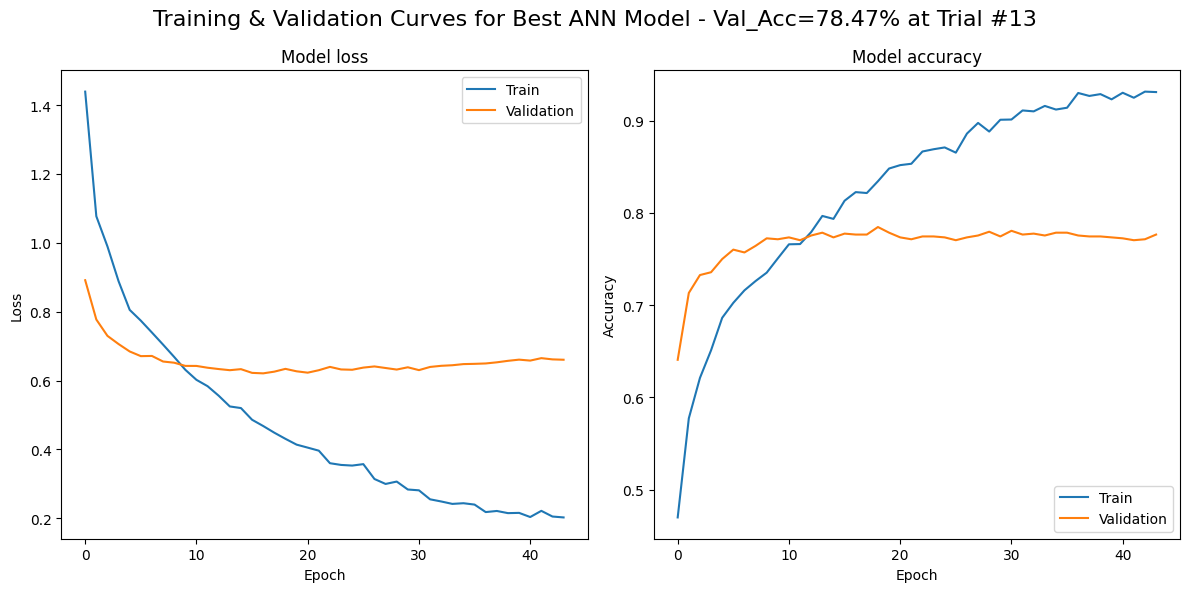

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


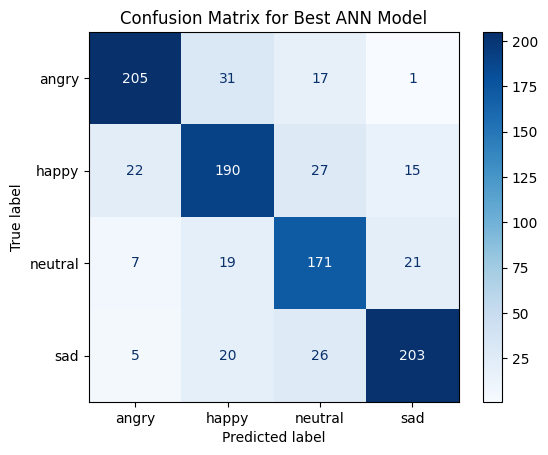


Accuracy = 78.469%

              precision    recall  f1-score   support

       angry       0.86      0.81      0.83       254
       happy       0.73      0.75      0.74       254
     neutral       0.71      0.78      0.75       218
         sad       0.85      0.80      0.82       254

    accuracy                           0.78       980
   macro avg       0.79      0.78      0.78       980
weighted avg       0.79      0.78      0.79       980



In [25]:
max_acc, best_params, best_trial, best_model, phist, histories = tune_hyperparams(ntrials=20,feats=feats,max_epochs=500)

In [27]:
def getRandomHPPMS():
    params = {}
    #params['rs_split'] = np.random.randint(0,1000)
    params['rs_split'] = 205
    params['num_HL'] = np.random.randint(3,4)
    for i in range(1,params['num_HL']+1):
        params[f'units_{i}'] = np.random.choice(range(64,512+2,2))
        params[f'KR_{i}'] = np.random.choice(['l1','l2','l1l2','none'])
        params[f'BN_{i}'] = np.random.choice([True,False])
        #params[f'dropout_rate_{i}'] = np.random.choice(np.round(np.arange(0,0.5+0.1,0.1),1))
        params[f'dropout_rate_{i}'] = np.round(np.random.uniform(0,0.5),4)
    params['learning_rate'] = np.random.uniform(0.001,0.003)
    optims = ['Adagrad']
    params['optimizer'] = np.random.choice(optims)
    params['batch_size'] = 84
    params['adpLR'] = True
    params['apply_smote'] = True
    return params

Trial 20 Complete [0h 0m 34s] - Trained for 99 epochs
train_accuracy = 99.877%
val_accuracy = 77.755%
Overfitting Difference = 22.122%

Best val_accuracy So Far: 79.286% at Trial #15
Total time elapsed: [0h 9m 59s]
Best Hyperparameters: {'rs_split': 205, 'num_HL': 3, 'units_1': 114, 'KR_1': 'l1', 'BN_1': False, 'dropout_rate_1': 0.4259, 'units_2': 360, 'KR_2': 'none', 'BN_2': True, 'dropout_rate_2': 0.4894, 'units_3': 194, 'KR_3': 'l1', 'BN_3': False, 'dropout_rate_3': 0.4971, 'learning_rate': 0.0022727044712147065, 'optimizer': 'Adagrad', 'batch_size': 84, 'adpLR': True, 'apply_smote': True}
Best Model Summary:


Model: "sequential_155"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_615 (Dense)               │ (None, 114)            │       726,636 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_460 (Dropout)           │ (None, 114)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_616 (Dense)               │ (None, 360)            │        41,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_224         │ (None, 360)            │         1,440 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_461 (Dropout)           │ (None, 360)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_617 (Dense)               │ (None, 194)            │        70,034 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_462 (Dropout)           │ (None, 194)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_618 (Dense)               │ (None, 4)              │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,679,862 (6.41 MB)

 Trainable params: 839,570 (3.20 MB)

 Non-trainable params: 720 (2.81 KB)

 Optimizer params: 839,572 (3.20 MB)

None


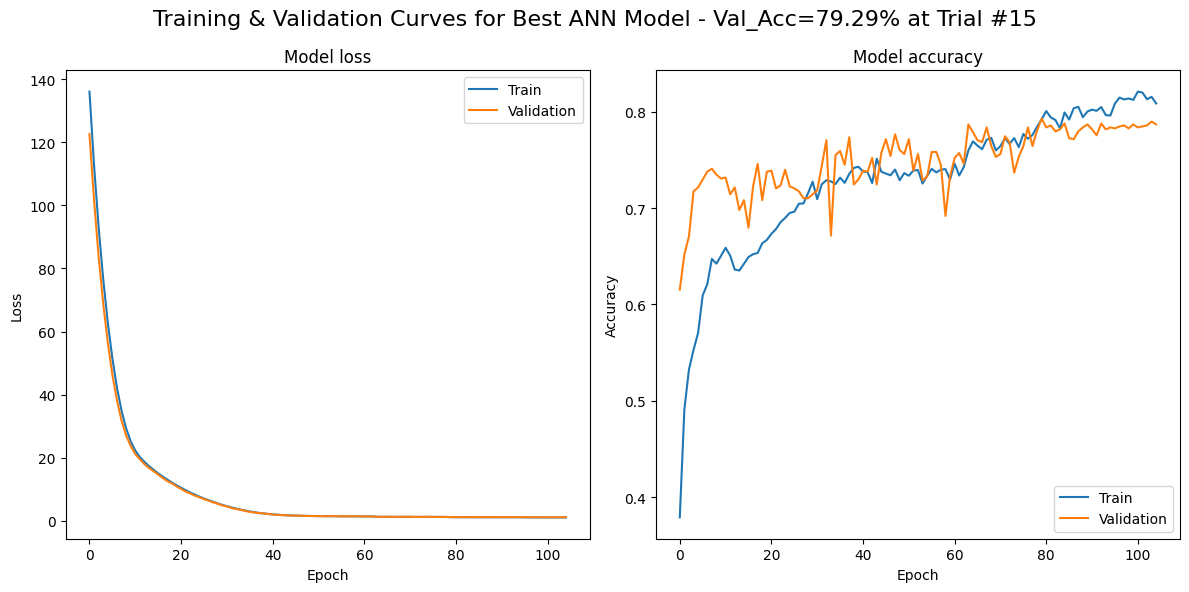

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


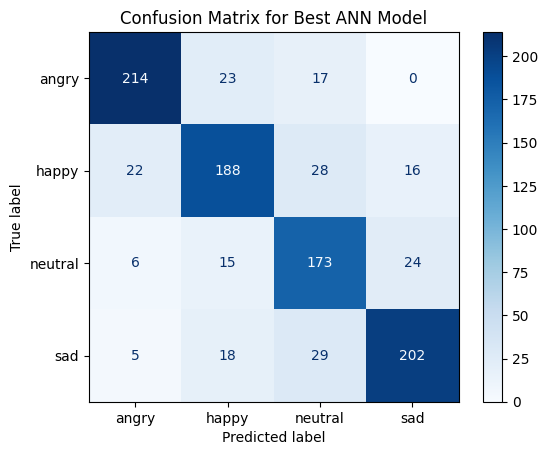


Accuracy = 79.286%

              precision    recall  f1-score   support

       angry       0.87      0.84      0.85       254
       happy       0.77      0.74      0.76       254
     neutral       0.70      0.79      0.74       218
         sad       0.83      0.80      0.81       254

    accuracy                           0.79       980
   macro avg       0.79      0.79      0.79       980
weighted avg       0.80      0.79      0.79       980



In [28]:
max_acc, best_params, best_trial, best_model, phist, histories = tune_hyperparams(ntrials=20,feats=feats,max_epochs=500)

In [29]:
data = []
for params, acc in phist.items():
    hppms = dict(params)
    hppms['accuracy'] = acc
    data.append(hppms)
df = pd.DataFrame(data)
df = df.reindex(sorted(df.columns), axis=1)
df = df[[col for col in sorted(df.columns) if col != 'accuracy'] + ['accuracy']]
df.sort_values('accuracy',ascending=False,inplace=True,ignore_index=True)
df

,BN_1,BN_2,BN_3,KR_1,KR_2,KR_3,adpLR,apply_smote,batch_size,dropout_rate_1,dropout_rate_2,dropout_rate_3,learning_rate,num_HL,optimizer,rs_split,units_1,units_2,units_3,accuracy
0,False,True,False,l1,none,l1,True,True,84,0.4259,0.4894,0.4971,0.002273,3,Adagrad,205,114,360,194,0.792857
1,False,False,True,l1,l2,l1,True,True,84,0.1139,0.3291,0.4966,0.002313,3,Adagrad,205,274,390,480,0.783673
2,False,False,False,l1l2,l1l2,l2,True,True,84,0.3373,0.4454,0.3805,0.001989,3,Adagrad,205,340,450,470,0.782653
3,False,True,False,l1,l2,l1l2,True,True,84,0.4436,0.2817,0.3234,0.001308,3,Adagrad,205,402,496,422,0.782653
4,False,False,False,none,l2,l2,True,True,84,0.0039,0.4919,0.2661,0.001343,3,Adagrad,205,312,498,188,0.777551
5,False,True,True,l2,l1,l1,True,True,84,0.1034,0.2495,0.2964,0.002635,3,Adagrad,205,192,140,380,0.777551
6,False,True,True,l2,l2,l1,True,True,84,0.4360,0.2510,0.3467,0.001024,3,Adagrad,205,296,116,252,0.775510
7,True,True,False,l2,l1,l1,True,True,84,0.4211,0.0326,0.3371,0.002984,3,Adagrad,205,124,500,136,0.773469
8,False,True,False,l2,l1l2,l1,True,True,84,0.4303,0.2967,0.1173,0.002274,3,Adagrad,205,254,242,164,0.773469
9,False,False,True,none,none,l1,True,True,84,0.0884,0.2834,0.1938,0.001413,3,Adagrad,205,200,386,380,0.771429


In [30]:
numerical_features = df.iloc[:,:-1].select_dtypes(include=['int64', 'float64'])
categorical_features = df.select_dtypes(include=['object', 'category','bool'])
correlation_matrix = numerical_features.corrwith(df['accuracy'], method='pearson')
print(correlation_matrix.sort_values(ascending=False))

dropout_rate_3    0.471985
dropout_rate_2    0.382070
units_2           0.332414
dropout_rate_1    0.265672
learning_rate     0.132934
units_3           0.085700
units_1          -0.004519
batch_size             NaN
num_HL                 NaN
rs_split               NaN
dtype: float64


/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [33]:
df['num_HL'].unique()

array([3])

In [36]:
df['total_do'] = df['dropout_rate_1']+df['dropout_rate_2']+df['dropout_rate_3']

In [41]:
numerical_features = df.drop(['accuracy'],axis=1).select_dtypes(include=['int64', 'float64'])
categorical_features = df.select_dtypes(include=['object', 'category','bool'])
correlation_matrix = numerical_features.corrwith(df['accuracy'], method='pearson')
print(correlation_matrix.sort_values(ascending=False))

total_do          0.622262
dropout_rate_3    0.471985
dropout_rate_2    0.382070
units_2           0.332414
dropout_rate_1    0.265672
learning_rate     0.132934
units_3           0.085700
units_1          -0.004519
batch_size             NaN
num_HL                 NaN
rs_split               NaN
dtype: float64


/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [34]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
for col in categorical_features:
    if len(df[col].unique())>1:
        model = ols(f'accuracy ~ C({col})', data=df).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        print(f"ANOVA result for {col}:\n", anova_table)

ANOVA result for BN_1:
             sum_sq    df         F    PR(>F)
C(BN_1)   0.000569   1.0  7.321198  0.014473
Residual  0.001398  18.0       NaN       NaN
ANOVA result for BN_2:
             sum_sq    df         F    PR(>F)
C(BN_2)   0.000060   1.0  0.570612  0.459787
Residual  0.001906  18.0       NaN       NaN
ANOVA result for BN_3:
             sum_sq    df         F    PR(>F)
C(BN_3)   0.000375   1.0  4.245955  0.054098
Residual  0.001591  18.0       NaN       NaN
ANOVA result for KR_1:
             sum_sq    df         F    PR(>F)
C(KR_1)   0.000266   3.0  0.832421  0.495432
Residual  0.001701  16.0       NaN       NaN
ANOVA result for KR_2:
             sum_sq    df         F    PR(>F)
C(KR_2)   0.000011   3.0  0.030462  0.992559
Residual  0.001956  16.0       NaN       NaN
ANOVA result for KR_3:
             sum_sq    df         F    PR(>F)
C(KR_3)   0.000777   3.0  3.480799  0.040704
Residual  0.001190  16.0       NaN       NaN


In [35]:
for col in categorical_features:
    if len(df[col].unique())>1:
        print(df.groupby(col)['accuracy'].mean().sort_values(ascending=False))

BN_1
False    0.774882
True     0.763703
Name: accuracy, dtype: float64
BN_2
True     0.772542
False    0.769048
Name: accuracy, dtype: float64
BN_3
False    0.776276
True     0.767432
Name: accuracy, dtype: float64
KR_1
l2      0.775000
l1      0.773761
none    0.767517
l1l2    0.765986
Name: accuracy, dtype: float64
KR_2
l1      0.772109
l1l2    0.771429
none    0.771429
l2      0.770181
Name: accuracy, dtype: float64
KR_3
l1      0.775612
l2      0.771173
l1l2    0.768707
none    0.757483
Name: accuracy, dtype: float64


In [42]:
def getRandomHPPMS():
    params = {}
    #params['rs_split'] = np.random.randint(0,1000)
    params['rs_split'] = 205
    params['num_HL'] = np.random.randint(3,4)
    for i in range(1,params['num_HL']+1):
        params[f'units_{i}'] = np.random.choice(range(64,512+2,2))
        params[f'KR_{i}'] = np.random.choice(['l1','l2','l1l2','none'])
        params[f'BN_{i}'] = np.random.choice([True,False])
        #params[f'dropout_rate_{i}'] = np.random.choice(np.round(np.arange(0,0.5+0.1,0.1),1))
        params[f'dropout_rate_{i}'] = np.round(np.random.uniform(0.3,0.5),4)
    params['learning_rate'] = np.random.uniform(0.001,0.003)
    optims = ['Adagrad']
    params['optimizer'] = np.random.choice(optims)
    params['batch_size'] = 84
    params['adpLR'] = True
    params['apply_smote'] = True
    return params

Trial 20 Complete [0h 0m 22s] - Trained for 44 epochs
train_accuracy = 94.199%
val_accuracy = 78.163%
Overfitting Difference = 16.035%

Best val_accuracy So Far: 79.184% at Trial #6
Total time elapsed: [0h 9m 13s]
Best Hyperparameters: {'rs_split': 205, 'num_HL': 3, 'units_1': 422, 'KR_1': 'l1', 'BN_1': True, 'dropout_rate_1': 0.4412, 'units_2': 66, 'KR_2': 'l1l2', 'BN_2': False, 'dropout_rate_2': 0.3557, 'units_3': 120, 'KR_3': 'l1', 'BN_3': False, 'dropout_rate_3': 0.4534, 'learning_rate': 0.001548756295359281, 'optimizer': 'Adagrad', 'batch_size': 84, 'adpLR': True, 'apply_smote': True}
Best Model Summary:


Model: "sequential_186"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_739 (Dense)               │ (None, 422)            │     2,689,828 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_270         │ (None, 422)            │         1,688 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_553 (Dropout)           │ (None, 422)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_740 (Dense)               │ (None, 66)             │        27,918 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_554 (Dropout)           │ (None, 66)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_741 (Dense)               │ (None, 120)            │         8,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_555 (Dropout)           │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_742 (Dense)               │ (None, 4)              │           484 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,455,074 (20.81 MB)

 Trainable params: 2,727,114 (10.40 MB)

 Non-trainable params: 844 (3.30 KB)

 Optimizer params: 2,727,116 (10.40 MB)

None


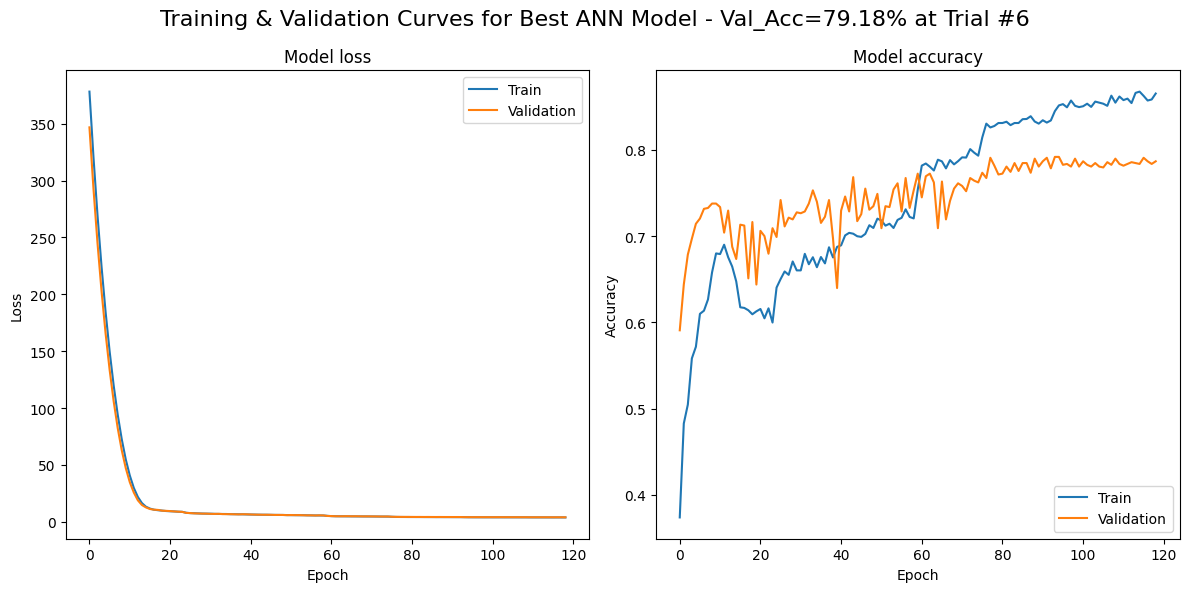

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


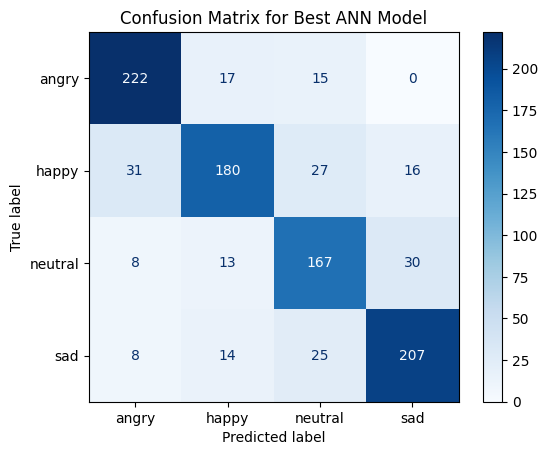


Accuracy = 79.184%

              precision    recall  f1-score   support

       angry       0.83      0.87      0.85       254
       happy       0.80      0.71      0.75       254
     neutral       0.71      0.77      0.74       218
         sad       0.82      0.81      0.82       254

    accuracy                           0.79       980
   macro avg       0.79      0.79      0.79       980
weighted avg       0.79      0.79      0.79       980



In [44]:
max_acc, best_params, best_trial, best_model, phist, histories = tune_hyperparams(ntrials=20,feats=feats,max_epochs=500)